## Forecasting "Unemployment rate" using ARIMA model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv(r"C:\Users\golna\OneDrive\Desktop\Personal Projects\UNRATE.csv")
df.head(10)

,observation_date,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5
5,1948-06-01,3.6
6,1948-07-01,3.6
7,1948-08-01,3.9
8,1948-09-01,3.8
9,1948-10-01,3.7


In [6]:
df['observation_date'] = pd.to_datetime(df['observation_date'])

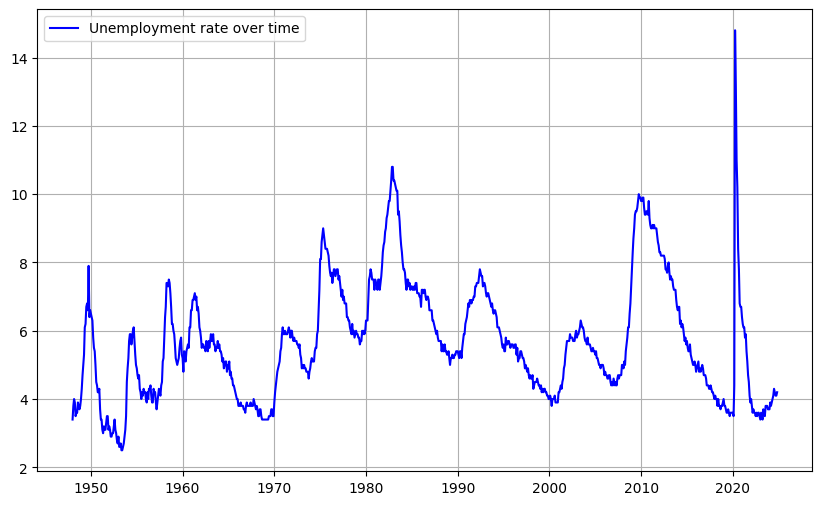

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(df['observation_date'], df['UNRATE'], label="Unemployment rate over time", color="blue")
xlabel="Time(monthly)"
yLabel="Unemployment rate"
plt.legend()
plt.grid(True)
plt.show()

In [88]:
from scipy.stats import skew, kurtosis

mean_unrate = df['UNRATE'].mean()
variance_unrate = df['UNRATE'].var()
skewness_unrate = skew(df['UNRATE'].dropna())
kurtosis_unrate = kurtosis(df['UNRATE'].dropna())
print(f"Mean: {mean_unrate}")
print(f"Variance: {variance_unrate}")
print(f"Skewness: {skewness_unrate}")
print(f"Kurtosis: {kurtosis_unrate}")

Mean: 8.65
Variance: 12.648596501465976
Skewness: -2.6356875609790943e-16
Kurtosis: -1.2000028232537296


In [89]:
from scipy.stats import jarque_bera

stat, p_value = jarque_bera(df['UNRATE'].dropna())
print(f"Jarque-Bera Test Statistic: {stat}")
print(f"P-value: {p_value}")
if p_value < 0.05:
    print("The data is not normally distributed (reject H0).")
else:
    print("The data is normally distributed (fail to reject H0).")

Jarque-Bera Test Statistic: 55.32026030430008
P-value: 9.713105506601519e-13
The data is not normally distributed (reject H0).


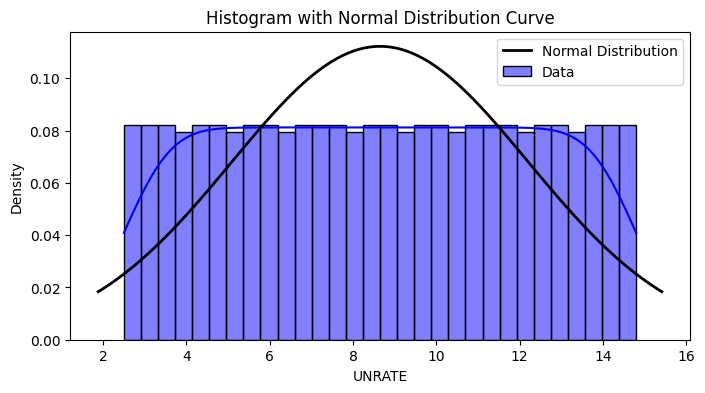

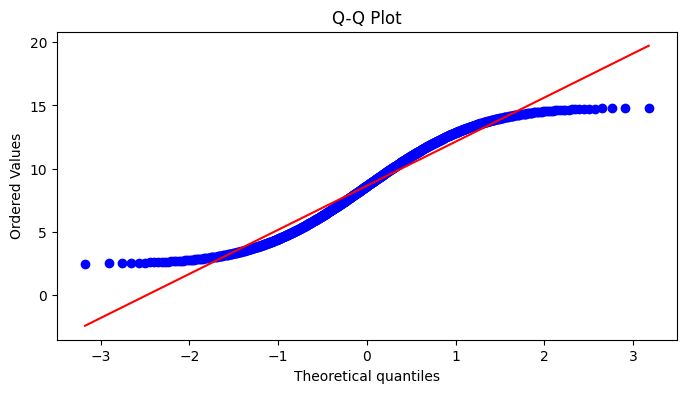

In [98]:
import seaborn as sns
from scipy import stats

plt.figure(figsize=(8, 4))
sns.histplot(df['UNRATE'], kde=True, stat="density", color='blue', bins=30, label='Data')
mu, std = stats.norm.fit(df['UNRATE'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution')
plt.title('Histogram with Normal Distribution Curve')
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
stats.probplot(df['UNRATE'], dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

## The time-series is symmetric but has heavy tails 
# Normality is not a strong assumption for ARIMA, however it is essential to have stationary data. BUT, we need to check residuals being a white noise process. 

In [84]:
msk = (df.index < len(df)-150)
df_train = df[msk].copy()
df_test = df[~msk].copy()
print(df_test)

    observation_data     UNRATE  UNRATE_diff  UNRATE_scaled
772       2012-05-31  12.810098     0.013355       1.170356
773       2012-06-30  12.823453     0.013355       1.174113
774       2012-07-31  12.836808     0.013355       1.177870
775       2012-08-31  12.850163     0.013355       1.181628
776       2012-09-30  12.863518     0.013355       1.185385
..               ...        ...          ...            ...
917       2024-06-30  14.746580     0.013355       1.715145
918       2024-07-31  14.759935     0.013355       1.718902
919       2024-08-31  14.773290     0.013355       1.722659
920       2024-09-30  14.786645     0.013355       1.726416
921       2024-10-31  14.800000     0.013355       1.730173

[150 rows x 4 columns]


In [12]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['UNRATE'].dropna())
print("Dickey Fuller Statistics:", result[0])
print("P-values:", result[1])
if result[1] <= 0.05:
    print("Time_series process is stationary.")
else: 
    print("Non-stationary time-series process")

Dickey Fuller Statistics: -3.925966418139469
P-values: 0.001851845344222856
Time_series process is stationary.


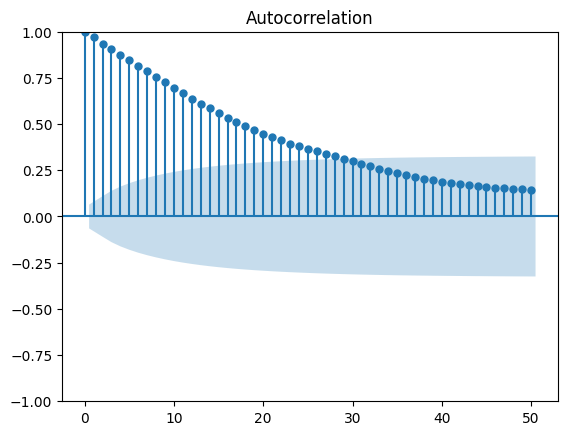

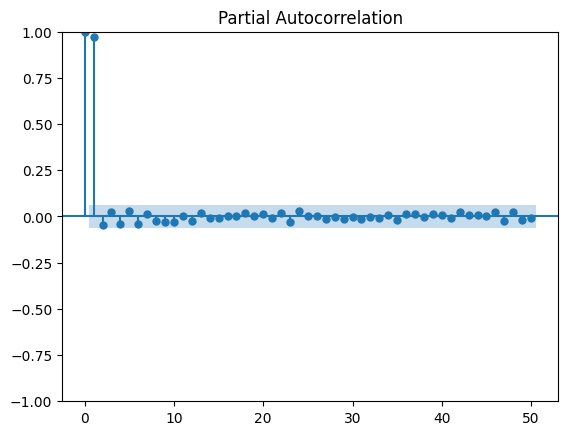

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['UNRATE'].dropna(), lags=50)
plot_pacf(df['UNRATE'].dropna(), lags=50)
plt.show()

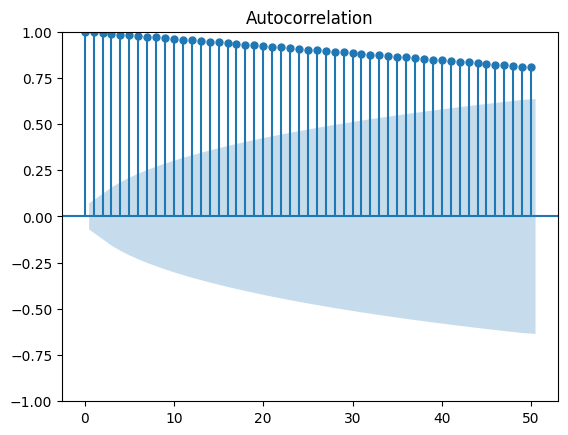

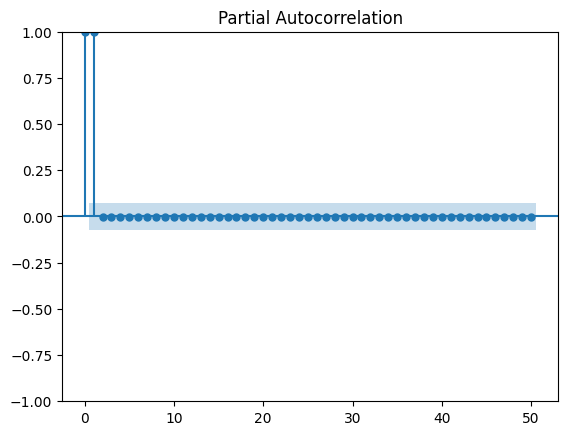

In [99]:
plot_acf(df_train['UNRATE'].dropna(), lags=50)
plot_pacf(df_train['UNRATE'].dropna(), lags=50)
plt.show()

## The ACF and PACF of the df_train, both show a random walk process. Random walk is a non-stationary process. So, we need to take a first difference of our main data and again, check for the ACF and PACF of the splitted data. 

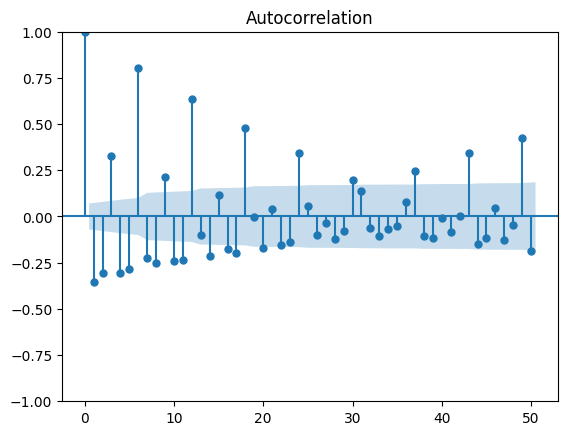

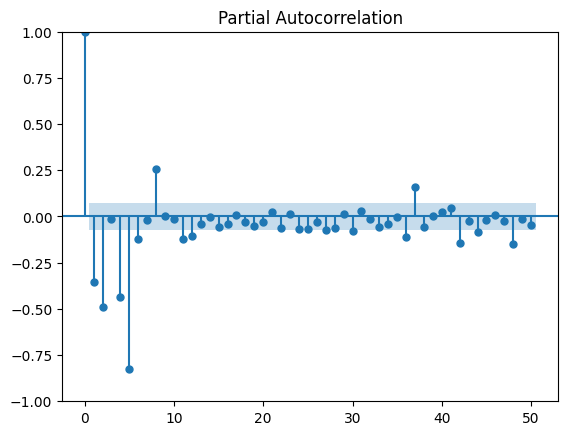

ADF Statistic: -40.616369361271346
p-value: 0.0


In [107]:
df_train['UNRATE_diff'] = df_train['UNRATE'].diff().dropna()
plot_acf(df_train['UNRATE_diff'].dropna(), lags=50)
plot_pacf(df_train['UNRATE_diff'].dropna(), lags=50)
plt.show()
result = adfuller(df_train['UNRATE_diff'].dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

## p_value is less than 0.05 however, looking at ACF one might see some kind of seasonality. 

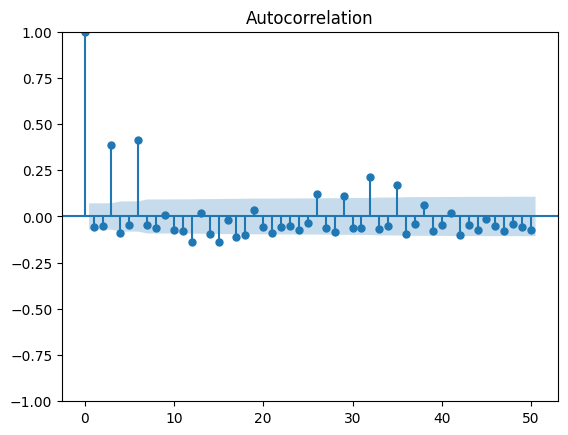

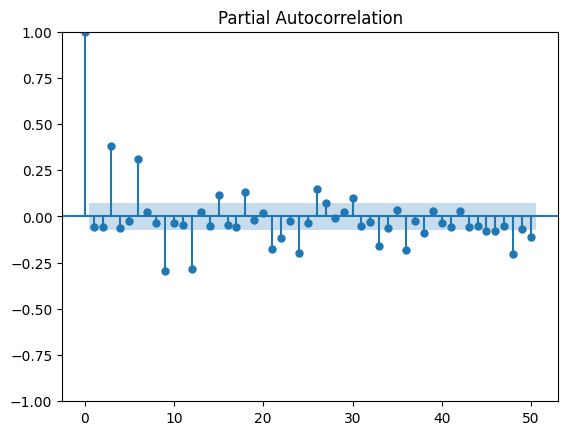

ADF Statistic: -9.131870257041887
p-value: 3.006873966722021e-15


In [106]:
df_train['UNRATE_seasonal_diff'] = df_train['UNRATE'] - df_train['UNRATE'].shift(12)
plot_acf(df_train['UNRATE_seasonal_diff'].dropna(), lags=50)
plot_pacf(df_train['UNRATE_seasonal_diff'].dropna(), lags=50)
plt.show()
result = adfuller(df_train['UNRATE_seasonal_diff'].dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

In [110]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df_train['UNRATE'], order=(3, 1, 3), seasonal_order=(3, 1, 3, 12))
fitted_model = model.fit()

print(fitted_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             UNRATE   No. Observations:                  772
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 12)   Log Likelihood                7421.022
Date:                            Sun, 12 Jan 2025   AIC                         -14816.044
Time:                                    17:23:44   BIC                         -14755.828
Sample:                                         0   HQIC                        -14792.854
                                            - 772                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6061   4.14e-21  -1.46e+20      0.000      -0.606      -0.606
ar.L2         -0.5521   1.71e-20  -

In [115]:
from statsmodels.stats.diagnostic import het_arch

residuals = fitted_model.resid
test_statistic, p_value, _, _ = het_arch(residuals)
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")

Test Statistic: 0.011582911675778407
P-value: 0.9999999999999459


# No sign of heteroskedasticity in residuals. We can also plot acf and pacf of residuals 

In [118]:
train_predictions = fitted_model.predict(start=0, end=len(df_train)-1, dynamic=False)
df_train['predictions'] = train_predictions 

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(df_train['UNRATE'], df_train['predictions'])
mse = mean_squared_error(df_train['UNRATE'], df_train['predictions'])
rmse = np.sqrt(mse)
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MAE: 0.005030505814248323
MSE: 0.010079342831361115
RMSE: 0.10039593035258508


<Figure size 1000x600 with 0 Axes>

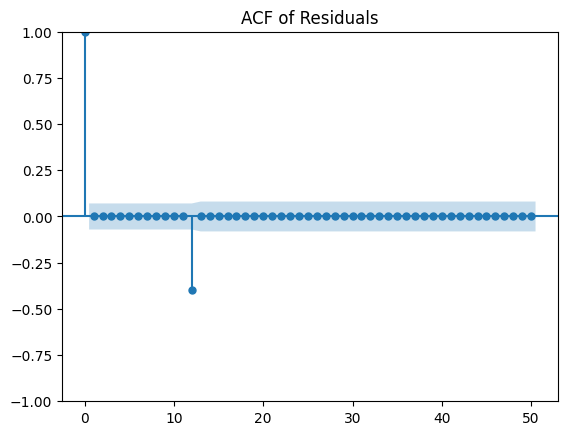

<Figure size 1000x600 with 0 Axes>

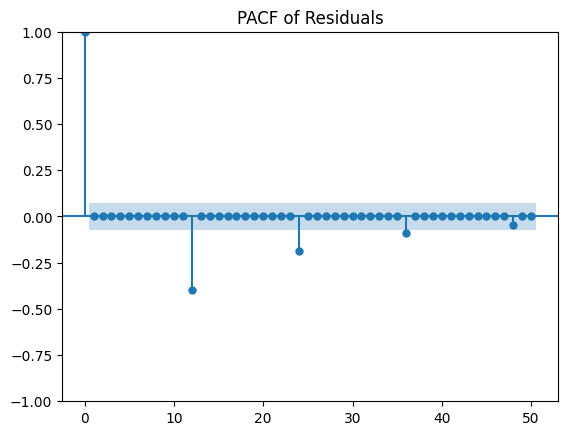

In [130]:
df_train['residuals'] = df_train['UNRATE'] - df_train['predictions']
plt.figure(figsize=(10, 6))
plot_acf(df_train['residuals'].dropna(), lags=50)
plt.title('ACF of Residuals')
plt.show()
plt.figure(figsize=(10, 6))
plot_pacf(df_train['residuals'].dropna(), lags=50)
plt.title('PACF of Residuals')
plt.show()

<Figure size 1000x600 with 0 Axes>

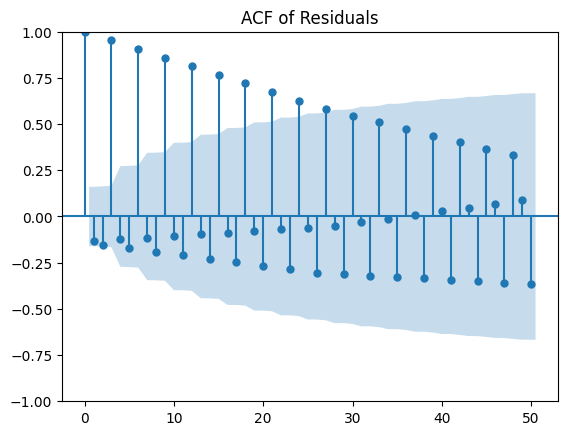

<Figure size 1000x600 with 0 Axes>

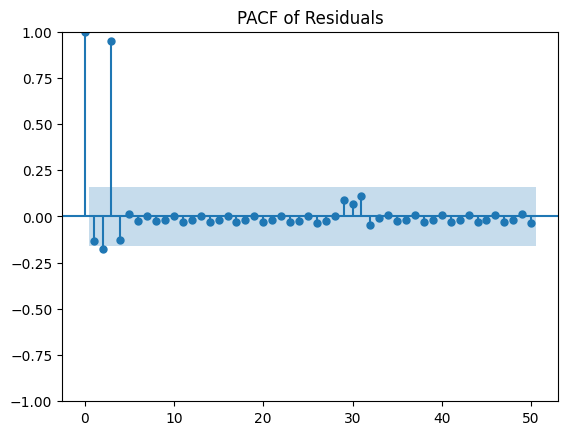

In [131]:
predictions = fitted_model.predict(start=len(df_train), end=len(df_train) + len(df_test) - 1, dynamic=False)
df_test['predictions'] = predictions

df_test['residuals'] = df_test['UNRATE'] - df_test['predictions']
plt.figure(figsize=(10, 6))
plot_acf(df_test['residuals'].dropna(), lags=50)
plt.title('ACF of Residuals')
plt.show()
plt.figure(figsize=(10, 6))
plot_pacf(df_test['residuals'].dropna(), lags=50)
plt.title('PACF of Residuals')
plt.show()

In [117]:
mae = mean_absolute_error(df_test['UNRATE'], df_test['predictions'])
mse = mean_squared_error(df_test['UNRATE'], df_test['predictions'])
rmse = np.sqrt(mse)
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MAE: 7.105427357601002e-16
MSE: 1.262177448353619e-30
RMSE: 1.1234667099445444e-15
